# Employee Churn

Employee turnover is a very costly problem for companies. The cost of replacing an employee is often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months. Survival analysis (also called Time-to-Event analysis) can be helpful in analyzing data about the employees and predicting when they are likely to quit.

This notebook uses the lifelines package to perform survival analysis and regression on a dataset containing some information about employees.

In [187]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import k_fold_cross_validation
from pathlib import Path
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [10]:
employees = pd.read_csv('employee_retention.csv', index_col=0)

In [11]:
employees.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [12]:
employees.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34702 entries, 0 to 34701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  34702 non-null  float64
 1   company_id   34702 non-null  int64  
 2   dept         34702 non-null  object 
 3   seniority    34702 non-null  int64  
 4   salary       34463 non-null  float64
 5   join_date    34702 non-null  object 
 6   quit_date    23510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 2.1+ MB


In [13]:
employees.describe()

,employee_id,company_id,seniority,salary
count,3.470200e+04,34702.000000,34702.000000,34463.000000
mean,6.466667e+05,4.023370,10.056625,100280.585004
std,3.337653e+05,2.911201,9.355505,87322.502536
min,3.600000e+01,1.000000,0.000000,5000.000000
25%,3.529228e+05,1.000000,0.000000,9302.000000
50%,7.063230e+05,3.000000,8.000000,88000.000000
75%,1.001324e+06,6.000000,18.000000,158000.000000
max,1.009999e+06,12.000000,99.000000,408000.000000


## Data Preprocessing

**Create duration and event columns**

In [83]:
df = employees.copy()
df[['join_date', 'quit_date']] = df[['join_date', 'quit_date']].astype('datetime64')
df.loc[pd.isna(df.quit_date), 'quit'] = 0
df['quit'] = df['quit'].fillna(1)
df.loc[df.quit==1, 'duration'] = (df['quit_date'] - df['join_date']).dt.days

**Missing data other than right censorship**

In [84]:
df.isna().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary           239
join_date          0
quit_date      11192
quit               0
duration       11192
dtype: int64

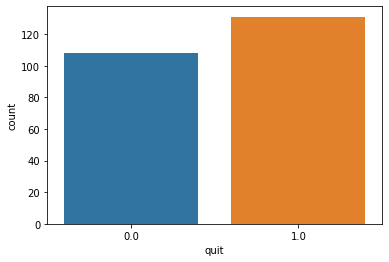

In [85]:
sns.countplot(df.loc[pd.isna(df.salary)]['quit'])

Since number of observations missing salary is very small we can remove these rows

In [86]:
df = df.loc[~pd.isna(df.salary)]

**Cleaning Data**

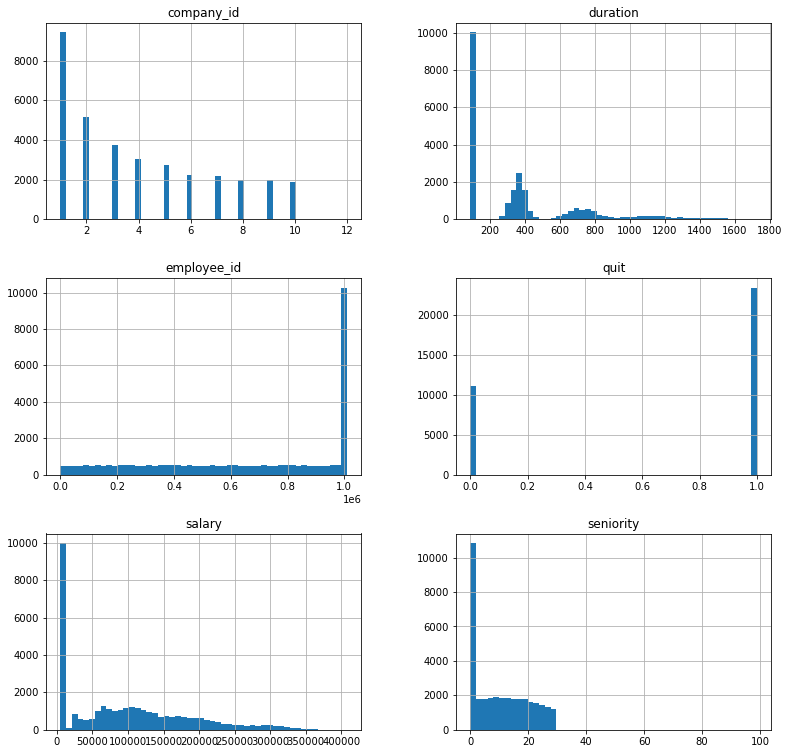

In [87]:
df.hist(bins=50, figsize=(13,13));

* Large number of samples with very low duration around 100 days
* Large number of samples at close to 0 salary
* Large number of samples at close to 0 seniority and an outlier in seniority.

Let's deal with these.

In [88]:
df.loc[df.duration<200]['dept'].value_counts()

temp_contractor     10000
customer_service        7
sales                   5
engineer                3
design                  1
marketing               1
data_science            1
Name: dept, dtype: int64

In [89]:
df.loc[df.dept=='temp_contractor'].describe()

,employee_id,company_id,seniority,salary,quit,duration
count,1.000000e+04,10000.000000,10000.0,10000.000000,10000.0,10000.0
mean,1.005000e+06,5.496600,0.0,7510.980100,1.0,90.0
std,2.886896e+03,2.890333,0.0,1439.510641,0.0,0.0
min,1.000000e+06,1.000000,0.0,5000.000000,1.0,90.0
25%,1.002500e+06,3.000000,0.0,6278.000000,1.0,90.0
50%,1.005000e+06,5.000000,0.0,7519.000000,1.0,90.0
75%,1.007499e+06,8.000000,0.0,8774.000000,1.0,90.0
max,1.009999e+06,10.000000,0.0,9999.000000,1.0,90.0


Looks like temporary contractors account for the employees with low durations, seniority and salary. They all quit (end contract) after 90 days so we will remove them from this analysis.

In [90]:
df = df.loc[df.dept!='temp_contractor']

In [91]:
df.seniority.nlargest()

26543    99
23683    98
21       29
49       29
275      29
Name: seniority, dtype: int64

In [92]:
df = df.loc[df.seniority<30]

In [94]:
end_date = max(df.join_date.max(), df.quit_date.max())
print(end_date)

2015-12-10 00:00:00


**Filling in duration for employees who have not quit yet**

In [95]:
df['duration'] = df['duration'].fillna((end_date - df.join_date).dt.days)

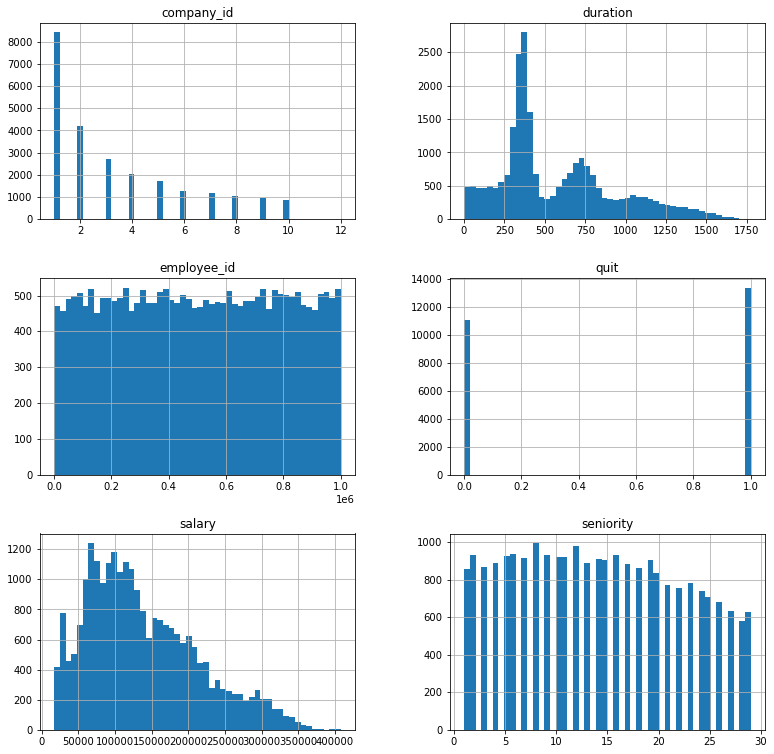

In [111]:
df.hist(bins=50, figsize=(13,13));

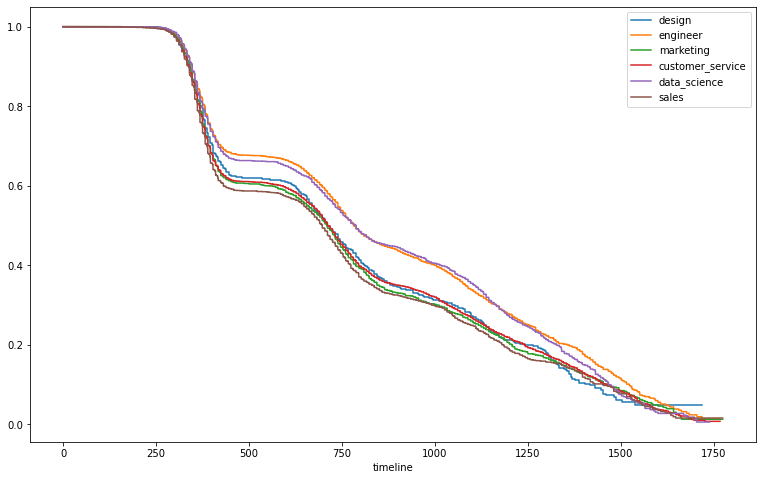

In [112]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(13,8))
for val in df['dept'].unique():
    dff = df.loc[df.dept==val].copy()
    kmf.fit(dff['duration'], event_observed=dff['quit'])
    kmf.plot(ci_show=False, ax=ax, label=val);

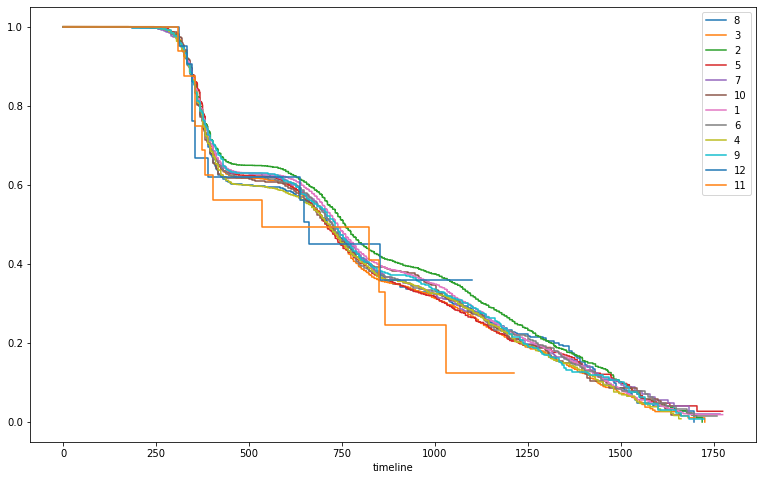

In [108]:
kmf = KaplanMeierFitter()
fig, ax = plt.subplots(figsize=(13,8))
for val in df['company_id'].unique():
    dff = df.loc[df.company_id==val].copy()
    kmf.fit(dff['duration'], event_observed=dff['quit'])
    kmf.plot(ci_show=False, ax=ax, label=val);

**Preparing data for survival regression**

In [ ]:
def plot_corr_map(data, center=None):
    f, ax = plt.subplots(figsize=(13, 9))
    corr = data.corr()
    hm = sns.heatmap(corr,
                     annot=True,
                     ax=ax,
                     cmap="coolwarm",
                     fmt='.2f',
                     linewidths=.05,
                     center=center)
    f.subplots_adjust(top=0.93)
    t = f.suptitle('Feature Correlation Heatmap', fontsize=16)
    return f

In [ ]:
def cv_score_statistics(regressor, data, duration_col='duration', event_col='event', scoring_method='concordance_index', k=5):
    scores = k_fold_cross_validation(regressor, data, duration_col, event_col, scoring_method='concordance_index', k=5)
    print('All scores:\n', np.sort(scores), '\n')
    print('Mean:', np.round(np.mean(scores), 3))
    print('SD:', np.round(np.std(scores), 3))

In [217]:
num_cols = ['seniority', 'salary']
cat_cols = ['dept']
preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), num_cols),
    ('encoder', OneHotEncoder(drop='first'), cat_cols),
    ('nothing', 'passthrough', ['duration', 'quit'])
],
                                 sparse_threshold=0)

In [218]:
X = preprocessor.fit_transform(df)
X = pd.DataFrame(X)
X.columns = num_cols + list(preprocessor.named_transformers_['encoder'].get_feature_names()) + ['duration', 'quit']

In [219]:
X.head()

,seniority,salary,x0_data_science,x0_design,x0_engineer,x0_marketing,x0_sales,duration,quit
0,0.853497,0.694271,0.0,1.0,0.0,0.0,0.0,304.0,1.0
1,-0.636291,-0.633681,0.0,1.0,0.0,0.0,0.0,1110.0,1.0
2,0.729348,2.101111,0.0,0.0,1.0,0.0,0.0,662.0,1.0
3,0.729348,0.549642,0.0,0.0,0.0,1.0,0.0,528.0,0.0
4,0.481050,-0.252388,0.0,0.0,0.0,0.0,0.0,634.0,1.0


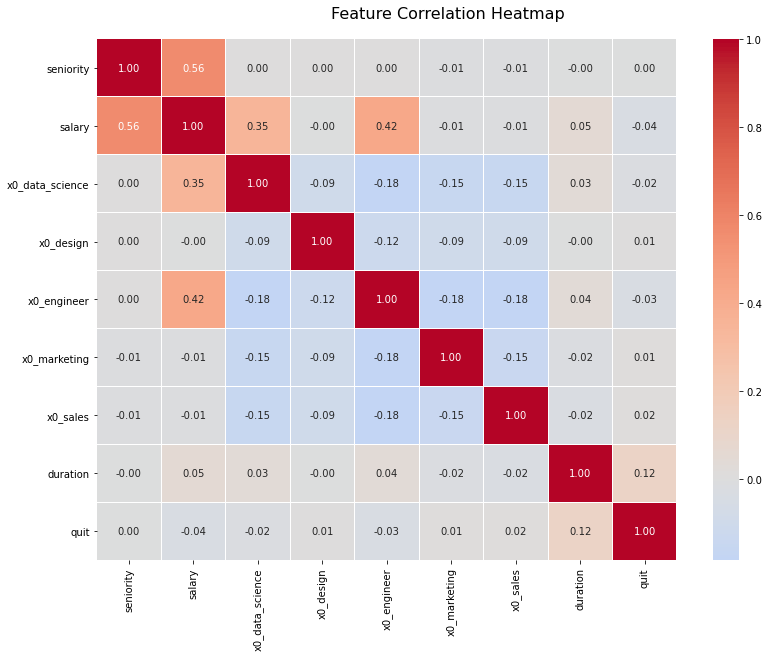

In [220]:
plot_corr_map(X, center=0);

In [221]:
cph = CoxPHFitter()
cph.fit(X, duration_col='duration', event_col='quit')

<lifelines.CoxPHFitter: fitted with 24461 total observations, 11084 right-censored observations>

In [222]:
cph.print_summary()

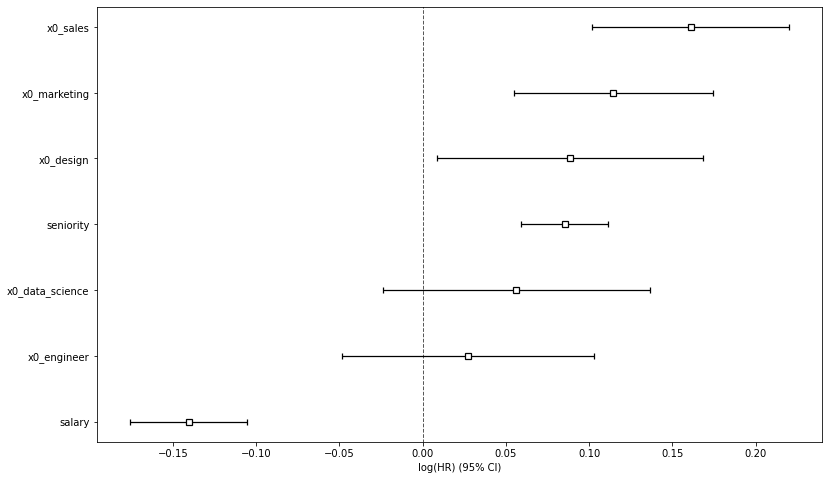

In [223]:
fig, ax = plt.subplots(figsize=(13,8))
cph.plot()

In [224]:
cv_score_statistics(cph, X, event_col='quit')

All scores:
 [0.52864462 0.52979032 0.5315084  0.53744557 0.54011413] 

Mean: 0.534
SD: 0.004


**Prediction on censored samples**

In [240]:
censored = X.loc[X.quit==0].copy()
censored_duration = censored['duration']
censored.loc[:, 'further'] = cph.predict_median(censored, conditional_after=censored_duration)
censored.loc[:, 'total'] = censored.duration + censored.further

In [241]:
censored

,seniority,salary,x0_data_science,x0_design,x0_engineer,x0_marketing,x0_sales,duration,quit,further,total
3,0.729348,0.549642,0.0,0.0,0.0,1.0,0.0,528.0,0.0,511.0,1039.0
6,0.232752,1.312229,1.0,0.0,0.0,0.0,0.0,717.0,0.0,491.0,1208.0
7,1.722540,0.365570,0.0,0.0,0.0,0.0,1.0,162.0,0.0,507.0,669.0
8,-1.381185,-0.804606,1.0,0.0,0.0,0.0,0.0,129.0,0.0,609.0,738.0
15,1.846689,1.128156,0.0,1.0,0.0,0.0,0.0,93.0,0.0,625.0,718.0
...,...,...,...,...,...,...,...,...,...,...,...
24449,-0.263844,0.050017,0.0,0.0,0.0,0.0,1.0,364.0,0.0,424.0,788.0
24450,1.101795,-0.199796,0.0,0.0,0.0,0.0,0.0,633.0,0.0,428.0,1061.0
24453,0.108603,1.009824,0.0,0.0,0.0,1.0,0.0,1396.0,0.0,148.0,1544.0
24455,-0.512142,-0.791458,0.0,0.0,0.0,0.0,0.0,87.0,0.0,644.0,731.0


**Employees who will stay two more years**

In [277]:
censored.loc[censored.further>730]

,seniority,salary,x0_data_science,x0_design,x0_engineer,x0_marketing,x0_sales,duration,quit,further,total
36,-0.512142,0.299830,0.0,0.0,1.0,0.0,0.0,15.0,0.0,752.0,767.0
50,-0.760440,0.497050,0.0,0.0,1.0,0.0,0.0,3.0,0.0,778.0,781.0
78,0.729348,3.047770,0.0,0.0,1.0,0.0,0.0,3.0,0.0,960.0,963.0
124,0.853497,2.087963,0.0,0.0,1.0,0.0,0.0,10.0,0.0,808.0,818.0
255,-0.512142,1.101860,0.0,0.0,1.0,0.0,0.0,73.0,0.0,736.0,809.0
...,...,...,...,...,...,...,...,...,...,...,...
24058,-0.263844,0.983528,1.0,0.0,0.0,0.0,0.0,31.0,0.0,755.0,786.0
24133,0.481050,2.679625,0.0,0.0,1.0,0.0,0.0,17.0,0.0,910.0,927.0
24236,-0.387993,1.036120,0.0,0.0,1.0,0.0,0.0,17.0,0.0,778.0,795.0
24385,0.108603,1.548894,0.0,0.0,1.0,0.0,0.0,1725.0,0.0,inf,inf
